In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from distutils.dir_util import copy_tree, remove_tree
from random import randint
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.applications import InceptionResNetV2, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import cv2
import keras

In [2]:
base='./data2/'
# root_dir='./'
test=base+"test/"
train=base+"train/"
wdr="./dataset3/"
if os.path.exists(wdr):
    remove_tree(wdr)
os.mkdir(wdr)
copy_tree(train,wdr)
copy_tree(test,wdr)
print("wdc:",os.listdir(wdr))

wdc: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:
work='./dataset3/'
classes=['glioma', 'meningioma', 'notumor', 'pituitary']
idm=176
ida=[176,208]
DIM=(idm,idm)

In [4]:
train_data_gen=IDG(rescale=1./255)
# train_data_gen=train_data_gen.flow_from_directory(directory=work,target_size=DIM,batch_size=6500)
train_data_gen = train_data_gen.flow_from_directory(directory=work, target_size=DIM, batch_size=6500 * 24) #12 for more good res

Found 10183 images belonging to 4 classes.


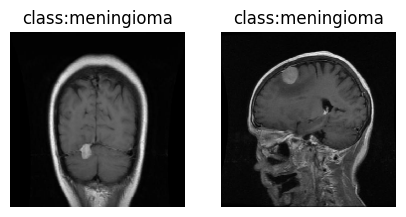

In [7]:
def show_images(generator):
    labels=dict(zip([0,1,2,3],classes))
    x,y=generator.next()
    plt.figure(figsize=(5,5))
    for i in range(2):
        ax=plt.subplot(2,2,i+1)
        idx=randint(0,200)
        plt.imshow(x[idx])
        plt.axis("off")
        plt.title("class:{}".format(labels[np.argmax(y[idx])]))

show_images(train_data_gen)

In [5]:
train_data,train_labels=train_data_gen.next()

In [6]:
sm=SMOTE(random_state=42)
train_data,train_labels=sm.fit_resample(train_data.reshape(-1,idm*idm*3),train_labels)
train_data=train_data.reshape(-1,idm,idm,3)
print(train_data.shape,train_labels.shape)

(10632, 176, 176, 3) (10632, 4)


In [7]:
train_data,test_data,train_labels,test_labels=train_test_split(train_data,train_labels,test_size=0.2,random_state=42)
train_data,val_data,train_labels,val_labels=train_test_split(train_data,train_labels,test_size=0.2,random_state=42)

In [8]:
base_model1 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(176,176,3))
base_model2= VGG19(weights='imagenet', include_top=False,input_shape=(176,176,3))

In [9]:
bm1_output = base_model1.output
bm2_output = base_model2.output

In [10]:
bm1_output = GlobalAveragePooling2D()(bm1_output)
bm2_output = GlobalAveragePooling2D()(bm2_output)

In [11]:
combined_output = concatenate([bm1_output, bm2_output])

In [12]:
x = Flatten()(combined_output)
x = Dense(512, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

combined_model = Model(inputs=[base_model1.input, base_model2.input], outputs=output)

In [13]:
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 176, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 87, 87, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 87, 87, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [22]:
combined_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss=CategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])
# Train the mode

In [23]:
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 176, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 87, 87, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 87, 87, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [24]:
combined_model.fit([train_data, train_data], train_labels,
                   validation_data=([val_data, val_data], val_labels),
                   epochs=10)

Epoch 1/10


c:\Users\Jaswanth\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


  6/213 [..............................] - ETA: 32:59 - loss: 3.3820 - accuracy: 0.5781

KeyboardInterrupt: 

In [1]:
import tensorflow as tf

# Check if a GPU is available
gpus = tf.config.list_physical_devices()

print(gpus)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:
import tensorflow as tf

tf.config.experimental.list_physical_devices('GPU')

[]